# Library

In [1]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from IPython.display import display
from wordcloud import WordCloud
from collections import Counter
from joblib import dump
from joblib import load
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import torch
import nltk
import re

# Classic Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Transformer Model
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import pipeline

# NLTK
from nltk import FreqDist
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [106]:
pip freeze > requirements.txt

In [2]:
pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 19.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=263d31ee417102d0db9333070a94c89a6402a5753556059c8e8e2c291c23c4b0
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [3]:
from langdetect import detect, detect_langs

In [4]:
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

# Read Data

In [5]:
!gdown "https://drive.google.com/uc?id=1z6amDVS_4IEherw9fHjegi9TVt750zPf"

Downloading...
From: https://drive.google.com/uc?id=1z6amDVS_4IEherw9fHjegi9TVt750zPf
To: /content/Womens Clothing E-Commerce Reviews.csv
100% 8.48M/8.48M [00:00<00:00, 34.8MB/s]


In [6]:
df = pd.read_csv('/content/Womens Clothing E-Commerce Reviews.csv')

In [7]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,General,Tops,Blouses


In [8]:
del df['Unnamed: 0']

# Objective
The goal is to improve customer feedback system on a e-commerce platform. In order to do that, We will build an NLP System that can automatically analyze product reviews to extract valuable insights. The project are:
1. Build a system to predict if a product will be recommended based on review text. Recommend (1) / Not Recommend (0).
2. Extract product attributes/aspects mentioned in reviews.
3. Analyze what is the most reasons why the product are Recommended and Not Recommended based on the extracted attributes/aspects.

# Exploratory Data Analysis
We will do some EDA to inspect the data quality.

## Check Data Shape

In [9]:
# Check Total Rows & Columns
num_row, num_col = df.shape
print('The dataset consist of {} rows and {} columns.'.format(num_row, num_col))

## The dataset size is not too small, around this size can provide sufficient examples for training a model.

The dataset consist of 23486 rows and 10 columns.


In [10]:
# Check Columns
print('Columns :', df.columns.values)

## The columns that we will focus on are Review Text and Recommended IND (Target Variable).
## Note: Because of the limited time, we will focus only for those two columns.

Columns : ['Clothing ID' 'Age' 'Title' 'Review Text' 'Rating' 'Recommended IND'
 'Positive Feedback Count' 'Division Name' 'Department Name' 'Class Name']


## Check Data Type

In [11]:
df.info()

## The Review Text and Recommended IND already has the correct data type.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              23486 non-null  int64 
 1   Age                      23486 non-null  int64 
 2   Title                    19676 non-null  object
 3   Review Text              22641 non-null  object
 4   Rating                   23486 non-null  int64 
 5   Recommended IND          23486 non-null  int64 
 6   Positive Feedback Count  23486 non-null  int64 
 7   Division Name            23472 non-null  object
 8   Department Name          23472 non-null  object
 9   Class Name               23472 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.8+ MB


## Check Missing Value

In [12]:
df[['Review Text', 'Recommended IND']].isna().sum()/len(df) # check null values proportion

## We can see that Recommended IND has no missing values.
## But for Review Text it has around ~3.5% missing values,
## We will remove all of these missing values.

,0
Review Text,0.035979
Recommended IND,0.000000


In [13]:
df_cleaned = df.dropna(subset=['Review Text'])
df_cleaned[['Review Text', 'Recommended IND']].isna().sum()/len(df_cleaned) # check null values proportion

,0
Review Text,0.0
Recommended IND,0.0


In [14]:
print('There are {} rows that has been removed'.format(df.shape[0] - df_cleaned.shape[0]))

There are 845 rows that has been removed


## Check Duplication

In [15]:
# Check for duplicates
duplicates = df_cleaned[df_cleaned.duplicated()]

# Add a column to indicate duplicates
df_cleaned['is_duplicate'] = df_cleaned.duplicated(keep=False)
df_sorted = df_cleaned.sort_values(by='is_duplicate', ascending=False)

# Show which are all the duplicates ones
df_sorted.loc[df_sorted.is_duplicate == True,:]

## There is only 1 duplicates that's not missing value for Review Text,

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,is_duplicate
9447,1022,37,NaN,"Love, love these jeans. being short they come right to my ankle. super soft and don?t require any hemming. i ordered my typical jean size of 26 and they fit like a glove. would love to have these in black and grey.",5,1,0,General,Bottoms,Jeans,True
21888,1022,37,NaN,"Love, love these jeans. being short they come right to my ankle. super soft and don?t require any hemming. i ordered my typical jean size of 26 and they fit like a glove. would love to have these in black and grey.",5,1,0,General,Bottoms,Jeans,True


In [16]:
print('Number of rows before duplicates data dropped: ', len(df_cleaned))
print('Number of rows after duplicates data dropped: ',len(df_cleaned.drop_duplicates()))
print('Number of duplicated rows: ' , len(df_cleaned) - len(df_cleaned.drop_duplicates()))

df_cleaned.drop_duplicates(inplace=True)

Number of rows before duplicates data dropped:  22641
Number of rows after duplicates data dropped:  22640
Number of duplicated rows:  1


In [17]:
df_cleaned = df_cleaned[['Review Text', 'Recommended IND']]

## Check Review Text

### Check Empty Reviews

In [18]:
print((df_cleaned['Review Text'] == '').sum())
## Conclusions: There is no empty reviews

0


### Check Review Text Length

<Axes: ylabel='Frequency'>

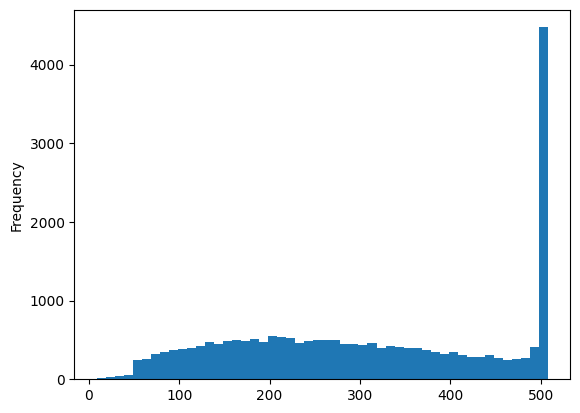

In [19]:
# Calculate review lengths and word count.
df_cleaned['review_length'] = df_cleaned['Review Text'].apply(len)
df_cleaned['word_count'] = df_cleaned['Review Text'].apply(lambda x: len(x.split()))

df_cleaned['review_length'].plot(kind='hist', bins=50)

## We can see from the below visualizations, there are more than 4000 reviews that has around 500 text length.

In [20]:
df_cleaned.word_count.min(), df_cleaned.word_count.max()

## We can see that, the shortest text has only 2 words in it and the longest text has 115 words.
## We will see if these 2 words or up to 5 words if they can add value or just noise.

(2, 115)

In [21]:
df_cleaned.loc[df_cleaned.word_count <= 5, :]

## We see that all of the short text review are meaningful and not ambigious, nonsensical or irrelevant like "okk", "hmm...".
## So, we will not filter/remove anything in here.

,Review Text,Recommended IND,review_length,word_count
859,Great style!,1,12,2
1637,Beautiful colors,1,16,2
1792,Super cute and flattering!,1,26,4
2978,Love embroidery!,1,16,2
4102,This is awesome multi-season dress.,1,35,5
4274,Love this top!,1,14,3
4386,Order a size down,1,17,4
4888,Got the green one,1,17,4
5925,Beautiful and delicate!!,1,24,3
7236,Comfy cozy!,1,11,2


### Check Class-Specific Insights
Usually positive reviews might be longer, because they tend to explain in very detail of their satisfaction, while negative reviews might be shorter (expressing frustration concisely).

In [22]:
df_cleaned.groupby('Recommended IND')['review_length'].describe()

## We can see that there is no insights we can get from here,
## because either positive and negative reviews has almost the same mean around ~300 words.

,count,mean,std,min,25%,50%,75%,max
Recommended IND,,,,,,,,
0,4101.0,318.334065,137.271966,20.0,203.0,316.0,461.0,508.0
1,18539.0,306.559200,145.293131,9.0,182.0,298.0,458.0,508.0


### Check if there is other language

In [23]:
# Detect the primary language for each review
for review in df_cleaned['Review Text'].values:
  if detect(review) != 'en':
    print(f"Review: {review}")
    print(f"Detected Language: {detect(review)}")  # Returns language code (e.g., 'en', 'fr', 'de')

## The result wasn't so good, so i just i didn't continue using this.
## I just took 50 random samples and too see if there is other language or not, but I didn't find any.

Review: Nice fabric and cute design. a little low cut.
Detected Language: ro
Review: Fits very strange. odd cut. does not look well on.
Detected Language: af
Review: Unusual color. expensive even on sale.
Detected Language: ro
Review: Beautiful colors
Detected Language: ro
Review: Love embroidery!
Detected Language: pt
Review: Very soft, cute design, great over leggings!
Detected Language: da
Review: Order a size down
Detected Language: pl
Review: Beautiful and delicate!!
Detected Language: ro
Review: Cute style, cute color, cute cut.  and i got it on sale!
Detected Language: ro
Review: Comfy cozy!
Detected Language: pl
Review: Great versatile skirt, very flattering
Detected Language: no
Review: I love birds
Detected Language: sl
Review: Beautiful design and fit.
Detected Language: fr
Review: Ooo la la! sooo chic! sooo retailer!!
Detected Language: so
Review: Cute blouse & great price !!
Detected Language: ro
Review: Low waisted, weird liner.
Detected Language: de
Review: Great structu

### Check Most Common Words

In [24]:
positive_reviews = df_cleaned[df_cleaned['Recommended IND'] == 1]['Review Text']
negative_reviews = df_cleaned[df_cleaned['Recommended IND'] == 0]['Review Text']
print(Counter(" ".join(positive_reviews).split()).most_common(10))

## These most common words isn't add much meaning, so next we need to remove this so called "stop words".
## But, stopword like "but" and "this" can carry semantic meaning,
## For example: "but" --> can signal contrasting opinions.
## For example: "this" --> might emphasizes specific products or features.
## So, we need to take a look at these 2 stopwords.

[('the', 58954), ('i', 40788), ('and', 40386), ('a', 35827), ('it', 29788), ('is', 25523), ('to', 19765), ('this', 16676), ('in', 16505), ('but', 12601)]


In [25]:
# df_cleaned.loc[df_cleaned['Review Text'].str.contains('this'),:].sample(n=5, random_state=42)
df_cleaned.loc[df_cleaned['Review Text'].str.contains('but'),:].sample(n=5, random_state=42)

## Well after, checking with few random samples, we can say stop words "but" and "this" add meaningful meaning,
## So, we will retain them.

,Review Text,Recommended IND,review_length,word_count
7880,"Fully lined until just above the knee, silk exterior, rayon lining. can dress it up or down. very lightweight and cool-feeling. this is a beautiful dress. i'm 5'9 and it fit great-- shorter people might need to alter it. i tried it on in the store and felt like a princess, but am hoping it goes on sale.",1,304,58
7421,"I fell in love with dress immediately! it runs small, but is very flattering, even if you have a little you want to hide. i went up 1 size. so comfy and beautiful! love!!",1,170,34
5295,Bought this top in black and i love it! fits true to size with arms a little snug but because of the stretch in the fabric it is fine. the top is very flattering and looked like the model. the front is shorter but very flattering! love it.,1,239,48
16999,"I see no one has reviewed this yet and since it is a beautiful sweater, and only available online, i thought i would contribute an opinion. the sweater is nicer in real life than the photo. it has a wonderful feel! the style: this sweater has very dramatic sleeves which i like though i could understand how that might annoy someone else. it is made with a heavy thick soft yarn so the sleeves hang nicely. i have worn it once and got complements so it is a sweater that while simple, is also a stand",1,500,96
8206,"I am so love in this top, i wish i had it in all colors and will absolutely be watching the sale rack for these ones. i love this top. i work out at a gym that requires tops, but that means i cannot usually display my awesome sports bras with cute strappy backs. this yoga top has an open back which will show these off, which i really like. the draped back keeps you nice and cool also. and the fit is amazing. i have some extra baby belly that i can't seem to work off-it was invisible in this top.",1,500,102


## Check Target Variable

### Target Distribution

In [26]:
# Calculate the distribution of the target variable
distribution_counts = df_cleaned['Recommended IND'].value_counts()  # Counts of each class
distribution_percent = df_cleaned['Recommended IND'].value_counts(normalize=True) * 100  # Percentage

display(distribution_counts)
display(distribution_percent)


## From the below results, we can see that the proportion for
## the positive class and negative class is imbalanced.

,count
Recommended IND,
1,18539
0,4101


,proportion
Recommended IND,
1,81.886042
0,18.113958


### Target Variable Quality

In [27]:
df_cleaned.loc[df_cleaned.word_count.index.isin([9121, 16863, 3863, 6532, 12032]), :]

## Some samples that shows the target variable is not that really true.
## You can see below from the first rows until fourth rows it should be recommended (1).
## And the fifth rows (I never write reviews), it doesn't have any meaning if it is recommended or not.

## Action: We can fix it or incorporating other columns like rating and title, maybe it can give some nuance or new insights, but for now we don't have time so leave it as is.

,Review Text,Recommended IND,review_length,word_count
3863,"I also have this dress in 3/4 sleeve, tegan tunic. i love this dress. it can be dressed up or down.",0,99,21
6532,"This jumpsuit runs large so i sized down perfectly one full size down. i have a size b chest and was very comfortable with no bra, as the built in cups gave me the perfect coverage. it looked like a dress standing, but had such a flattering and fun shape when you move. everyone loved it!",0,288,56
9121,"Very pretty, romantic",0,21,3
12032,"Yes,you need these, so comfortable - and wash up perfectly - workout, walking or great to sleep in",0,98,18
16863,I never write reviews,0,21,4


# Data Splitting

In [28]:
# Split dataset into train_set (60%) + valid_set (20%) + test_set (20%)
df_full_train, df_test = train_test_split(df_cleaned, stratify=df_cleaned['Recommended IND'], test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, stratify=df_full_train['Recommended IND'],  test_size=0.25, random_state=1)

In [29]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [30]:
X_train = df_train[['Review Text']]
y_train = df_train[['Recommended IND']]

X_val = df_val[['Review Text']]
y_val = df_val[['Recommended IND']]

X_test = df_test[['Review Text']]
y_test = df_test[['Recommended IND']]

# Data Preprocessing

In [31]:
df_cleaned.head(2)

,Review Text,Recommended IND,review_length,word_count
0,Absolutely wonderful - silky and sexy and comfortable,1,53,8
1,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",1,303,62


## Text Cleaning

In [32]:
stop_words = set(stopwords.words('english'))
# Remove 'but' and 'this' as we know from before these 2 words are important.
stop_words.remove('but')
stop_words.remove('this')

In [33]:
def remove_parentheses(text):
    pattern = r'\(.*?\)'
    text = re.sub(pattern, "", text)
    return text

def remove_numbers(text):
    text = re.sub(r'\d+', '', text)
    return text

def remove_punctuation(text):
    punctuation_pattern = r'[^\w\s]'
    cleaned_text = re.sub(punctuation_pattern, ' ', text)
    return cleaned_text

def remove_extra_spaces(text):
    extra_spaces_pattern = r"\s+"
    cleaned_text = re.sub(extra_spaces_pattern, " ", text)
    cleaned_text = cleaned_text.strip()
    return cleaned_text

def remove_special_characters(text):
    cleaned_text = re.sub(r'[^A-Za-z0-9\s]', ' ', text)
    return cleaned_text

def lowercase(text):
    lowercase_text = text.lower()
    return lowercase_text

def remove_stopwords(text, stopwords=stop_words):
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    cleaned_text = ' '.join(filtered_tokens)
    return cleaned_text

In [34]:
def preprocessing(df, col, prep_col):
    # Apply preprocessing functions to article column
    df[prep_col] = df[col].apply(remove_parentheses)
    df[prep_col] = df[prep_col].apply(remove_numbers)
    df[prep_col] = df[prep_col].apply(remove_punctuation)
    df[prep_col] = df[prep_col].apply(remove_extra_spaces)
    df[prep_col] = df[prep_col].apply(remove_special_characters)
    df[prep_col] = df[prep_col].apply(lowercase)
    df[prep_col] = df[prep_col].apply(remove_stopwords)
    return df

In [35]:
X_train = preprocessing(X_train, "Review Text", "Review Text Preprocessed")
X_val = preprocessing(X_val, "Review Text", "Review Text Preprocessed")
X_test = preprocessing(X_test, "Review Text", "Review Text Preprocessed")

In [36]:
display(X_train.head(2))
display(X_val.head(2))
display(X_test.head(2))

,Review Text,Review Text Preprocessed
0,"At 5'4"" i typically order petite clothing...i was unsure of this dress/tunic-shirt from the photos online, the reviews and the hi/low hem. i ordered xs and pxs (about 118#). both fit as far as shoulders and through the body but the pxs was way too short on me to wear as a dress without any leggings. the length of the regular xs works great and i feel is appropriate for someone my age! it is buttery soft and so comfortable. i ordered the suede wrap belt to go with it. also, the sleeves are too ti",typically order petite clothing unsure this dress tunic shirt photos online reviews hi low hem ordered xs pxs fit far shoulders body but pxs way short wear dress without leggings length regular xs works great feel appropriate someone age buttery soft comfortable ordered suede wrap belt go also sleeves ti
1,I seriously wanted to cry when this dress didn't fit me. i knew ordering it that it was a long shot. i'm a 36d and strapless rarely works. this was no different. the dress ran true to size and it is precious!,seriously wanted cry this dress fit knew ordering long shot strapless rarely works this different dress ran true size precious


,Review Text,Review Text Preprocessed
0,I ordered this shirt online and didn't even try it on... it is super see through and i would need to wear a tank underneath and i don't want to have that extra layer in the summer.\r\nit is cute though!,ordered this shirt online even try super see would need wear tank underneath want extra layer summer cute though
1,"This shirt is not a good look for a gal with hips. the fit at the top is tight (i ordered a small) but there is so much material at the bottom and if you are a little taller (i am 5'7), it hits at a place that is not flattering. i was hoping for something that hung straight down and would be good with leggings. this is not it...also the material is a little stiffer then i was expecting.",this shirt good look gal hips fit top tight but much material bottom little taller hits place flattering hoping something hung straight would good leggings this also material little stiffer expecting


,Review Text,Review Text Preprocessed
0,"This is the cutest poncho style sweater (but the arms aren't attached like a true poncho. it doesn't work for a petite customer, unfortunately, but on average sized it's gorgeous. so pretty.",this cutest poncho style sweater but arms attached like true poncho work petite customer unfortunately but average sized gorgeous pretty
1,"I am a 10 m and got the 10. it fits perfectly and there is room in the bust (i'm 36/38 c). the shirt feels very nice and silky up to the skin. i'm just not sure about the print- i got the umbrellas. it's cute, but maybe a little too cartoonish? it does look good with a green or blue puffy vest for colder days...still trying to decide if i should keep or return, but only b/c of the print. i'd love this in some solid colors!",got fits perfectly room bust shirt feels nice silky skin sure print got umbrellas cute but maybe little cartoonish look good green blue puffy vest colder days still trying decide keep return but b c print love this solid colors


## Text Normalization

In [37]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatization(text):
    # Step 1: Tokenize the text
    tokens = word_tokenize(text)

    # Step 2: Lemmatize each word
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(lemmatized_tokens)

In [38]:
X_train['Review Text Preprocessed Lemma'] = X_train['Review Text Preprocessed'].apply(lemmatization)
X_val['Review Text Preprocessed Lemma'] = X_val['Review Text Preprocessed'].apply(lemmatization)
X_test['Review Text Preprocessed Lemma'] = X_test['Review Text Preprocessed'].apply(lemmatization)

In [39]:
display(X_train.head(2))
display(X_val.head(2))
display(X_test.head(2))

,Review Text,Review Text Preprocessed,Review Text Preprocessed Lemma
0,"At 5'4"" i typically order petite clothing...i was unsure of this dress/tunic-shirt from the photos online, the reviews and the hi/low hem. i ordered xs and pxs (about 118#). both fit as far as shoulders and through the body but the pxs was way too short on me to wear as a dress without any leggings. the length of the regular xs works great and i feel is appropriate for someone my age! it is buttery soft and so comfortable. i ordered the suede wrap belt to go with it. also, the sleeves are too ti",typically order petite clothing unsure this dress tunic shirt photos online reviews hi low hem ordered xs pxs fit far shoulders body but pxs way short wear dress without leggings length regular xs works great feel appropriate someone age buttery soft comfortable ordered suede wrap belt go also sleeves ti,typically order petite clothing unsure this dress tunic shirt photo online review hi low hem ordered x px fit far shoulder body but px way short wear dress without legging length regular x work great feel appropriate someone age buttery soft comfortable ordered suede wrap belt go also sleeve ti
1,I seriously wanted to cry when this dress didn't fit me. i knew ordering it that it was a long shot. i'm a 36d and strapless rarely works. this was no different. the dress ran true to size and it is precious!,seriously wanted cry this dress fit knew ordering long shot strapless rarely works this different dress ran true size precious,seriously wanted cry this dress fit knew ordering long shot strapless rarely work this different dress ran true size precious


,Review Text,Review Text Preprocessed,Review Text Preprocessed Lemma
0,I ordered this shirt online and didn't even try it on... it is super see through and i would need to wear a tank underneath and i don't want to have that extra layer in the summer.\r\nit is cute though!,ordered this shirt online even try super see would need wear tank underneath want extra layer summer cute though,ordered this shirt online even try super see would need wear tank underneath want extra layer summer cute though
1,"This shirt is not a good look for a gal with hips. the fit at the top is tight (i ordered a small) but there is so much material at the bottom and if you are a little taller (i am 5'7), it hits at a place that is not flattering. i was hoping for something that hung straight down and would be good with leggings. this is not it...also the material is a little stiffer then i was expecting.",this shirt good look gal hips fit top tight but much material bottom little taller hits place flattering hoping something hung straight would good leggings this also material little stiffer expecting,this shirt good look gal hip fit top tight but much material bottom little taller hit place flattering hoping something hung straight would good legging this also material little stiffer expecting


,Review Text,Review Text Preprocessed,Review Text Preprocessed Lemma
0,"This is the cutest poncho style sweater (but the arms aren't attached like a true poncho. it doesn't work for a petite customer, unfortunately, but on average sized it's gorgeous. so pretty.",this cutest poncho style sweater but arms attached like true poncho work petite customer unfortunately but average sized gorgeous pretty,this cutest poncho style sweater but arm attached like true poncho work petite customer unfortunately but average sized gorgeous pretty
1,"I am a 10 m and got the 10. it fits perfectly and there is room in the bust (i'm 36/38 c). the shirt feels very nice and silky up to the skin. i'm just not sure about the print- i got the umbrellas. it's cute, but maybe a little too cartoonish? it does look good with a green or blue puffy vest for colder days...still trying to decide if i should keep or return, but only b/c of the print. i'd love this in some solid colors!",got fits perfectly room bust shirt feels nice silky skin sure print got umbrellas cute but maybe little cartoonish look good green blue puffy vest colder days still trying decide keep return but b c print love this solid colors,got fit perfectly room bust shirt feel nice silky skin sure print got umbrella cute but maybe little cartoonish look good green blue puffy vest colder day still trying decide keep return but b c print love this solid color


## Text Vectorizing: TF-IDF
Let's use the most common used for classic models. Frequency-Based Text Vectorization: TF-IDF.

In [40]:
## For now let's use the default parameter for TF-IDF Vectorizer because we don't have much time.
# Step 1: Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Step 2: Fit and transform the data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['Review Text Preprocessed Lemma'])

# Step 3: Get feature names (unique words in the vocabulary)
feature_names = tfidf_vectorizer.get_feature_names_out()

In [41]:
tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=feature_names)

In [42]:
# Transform both validation and test data
X_val_tfidf = tfidf_vectorizer.transform(X_val['Review Text Preprocessed Lemma'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['Review Text Preprocessed Lemma'])

## Handling Imbalanced
Let's also use the common imbalancing method which is SMOTE for the sake of time.

In [43]:
print("Before Balancing:")
print("Training class distribution:")
display(y_train.value_counts(normalize=True) * 100)


# Step 2: Handle imbalance in the training set using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)

print("After Balancing:")
print("Training class distribution:")
display(y_train_balanced.value_counts(normalize=True) * 100)


# Validation and test sets remain imbalanced
print("Validation class distribution:")
display(y_val.value_counts(normalize=True) * 100)

print("Test class distribution:")
display(y_test.value_counts(normalize=True) * 100)

Before Balancing:
Training class distribution:


,proportion
Recommended IND,
1,81.883098
0,18.116902


After Balancing:
Training class distribution:


,proportion
Recommended IND,
0,50.0
1,50.0


Validation class distribution:


,proportion
Recommended IND,
1,81.890459
0,18.109541


Test class distribution:


,proportion
Recommended IND,
1,81.890459
0,18.109541


# Modelling
- Modify the loss function to account for class imbalance.

## Benchmark: Logistic Regression

In [96]:
model = LogisticRegression(random_state=42)
model.fit(X_train_balanced, y_train_balanced)

LogisticRegression(random_state=42)

In [97]:
# Save the model
dump(model, 'logreg_v1.joblib')

['logreg_v1.joblib']

In [105]:
# Load the model back for inference
logreg = load('logreg_v1.joblib')

In [ ]:
y_pred = logreg.predict(X_val_tfidf)
y_pred_proba = logreg.predict_proba(X_val_tfidf)[:, 1]

In [ ]:
# Calculate F1-Score
logreg_f1 = f1_score(y_val, y_pred, average='binary')  # For binary classification
logreg_roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"F1-Score: {logreg_f1}")

print()

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

print()

print("AUC-ROC Score:")
print(logreg_roc_auc)

Accuracy: 0.8765459363957597
F1-Score: 0.9216757741347905

Confusion Matrix:
[[ 680  140]
 [ 419 3289]]

AUC-ROC Score:
0.9276952271949904


## Other Classical Models

In [95]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [94]:
list_accuracy = [logreg_accuracy]
list_f1_score = [logreg_f1]

In [98]:
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_val_tfidf)
    y_pred_proba = model.predict_proba(X_val_tfidf)[:, 1]

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    list_accuracy.append(accuracy)
    list_f1_score.append(f1)
    # Evaluate Metrics
    print(f"{model_name} Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))
    print(f"Accuracy: {accuracy}")
    print(f"F1-Score: {f1}")

    model_filename = model_name + '_v1' + '.joblib'
    dump(model, model_filename)


Training Random Forest...
Random Forest Confusion Matrix:
[[ 393  427]
 [ 164 3544]]
Accuracy: 0.8694787985865724
F1-Score: 0.9230368537569996

Training XGBoost...
XGBoost Confusion Matrix:
[[ 465  355]
 [ 188 3520]]
Accuracy: 0.8800795053003534
F1-Score: 0.9283924568112885


In [107]:
# Load the model back for inference
logreg = load('logreg_v1.joblib')
rf = load('Random Forest_v1.joblib')
xgb = load('XGBoost_v1.joblib')

In [108]:
y_train_pred_logreg = logreg.predict(X_train_tfidf)
y_train_pred_proba_logreg = logreg.predict_proba(X_train_tfidf)[:, 1]

y_train_pred_rf = rf.predict(X_train_tfidf)
y_train_pred_proba_rf = rf.predict_proba(X_train_tfidf)[:, 1]

y_train_pred_xgb = xgb.predict(X_train_tfidf)
y_train_pred_proba_xgb = xgb.predict_proba(X_train_tfidf)[:, 1]

In [109]:
y_val_pred_proba_logreg = logreg.predict_proba(X_val_tfidf)[:, 1]
y_val_pred_proba_rf = rf.predict_proba(X_val_tfidf)[:, 1]
y_val_pred_proba_xgb = xgb.predict_proba(X_val_tfidf)[:, 1]

In [114]:
y_test_pred_logreg = logreg.predict(X_test_tfidf)
y_test_pred_proba_logreg = logreg.predict_proba(X_test_tfidf)[:, 1]

y_test_pred_rf = rf.predict(X_test_tfidf)
y_test_pred_proba_rf = rf.predict_proba(X_test_tfidf)[:, 1]

y_test_pred_xgb = xgb.predict(X_test_tfidf)
y_test_pred_proba_xgb = xgb.predict_proba(X_test_tfidf)[:, 1]

In [110]:
# Calculate F1-Score and ROC-AUC
logreg_f1 = f1_score(y_train, y_train_pred_logreg, average='binary')
logreg_roc_auc = roc_auc_score(y_train, y_train_pred_proba_logreg)

rf_f1 = f1_score(y_train, y_train_pred_rf, average='binary')
rf_roc_auc = roc_auc_score(y_train, y_train_pred_proba_rf)

xgb_f1 = f1_score(y_train, y_train_pred_xgb, average='binary')
xgb_roc_auc = roc_auc_score(y_train, y_train_pred_proba_xgb)

train_list_roc_auc = [logreg_roc_auc, rf_roc_auc, xgb_roc_auc]
train_list_f1 = [logreg_f1, rf_f1, xgb_f1]

In [115]:
# Calculate F1-Score and ROC-AUC
logreg_f1 = f1_score(y_test, y_test_pred_logreg, average='binary')
logreg_roc_auc = roc_auc_score(y_test, y_test_pred_proba_logreg)

rf_f1 = f1_score(y_test, y_test_pred_rf, average='binary')
rf_roc_auc = roc_auc_score(y_test, y_test_pred_proba_rf)

xgb_f1 = f1_score(y_test, y_test_pred_xgb, average='binary')
xgb_roc_auc = roc_auc_score(y_test, y_test_pred_proba_xgb)

test_list_roc_auc = [logreg_roc_auc, rf_roc_auc, xgb_roc_auc]
test_list_f1 = [logreg_f1, rf_f1, xgb_f1]

In [111]:
logreg_roc_auc = roc_auc_score(y_val, y_val_pred_proba_logreg)
rf_roc_auc = roc_auc_score(y_val, y_val_pred_proba_rf)
xgb_roc_auc = roc_auc_score(y_val, y_val_pred_proba_xgb)

val_list_roc_auc = [logreg_roc_auc, rf_roc_auc, xgb_roc_auc]

In [100]:
all_model_name = ['Logistic Regression', 'Random Forest', 'XGBoost']

In [121]:
model_results = pd.DataFrame({
    'Model_Name': all_model_name,
    'Train_ROC_AUC': train_list_roc_auc,
    'Val_ROC_AUC': val_list_roc_auc,
    'Test_ROC_AUC': test_list_roc_auc,
    'Train_F1_Score': train_list_f1,
    'Val_F1_Score ': list_f1_score,
    'Test_F1_Score': test_list_f1
})

In [122]:
model_results

,Model_Name,Train_ROC_AUC,Val_ROC_AUC,Test_ROC_AUC,Train_F1_Score,Val_F1_Score,Test_F1_Score
0,Logistic Regression,0.965187,0.927695,0.921321,0.943672,0.921676,0.918634
1,Random Forest,1.000000,0.891803,0.895579,1.000000,0.923037,0.920759
2,XGBoost,0.982660,0.908332,0.904700,0.967702,0.928392,0.925184


## Modern Transformer-Based Models

In [44]:
# GPU check available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [45]:
# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)  # 2 classes: negative and positive
model.to(device) # using gpu cuda

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [51]:
# Tokenize data
train_encodings = tokenizer(X_train['Review Text Preprocessed Lemma'].tolist(), padding=True, truncation=True, max_length=128)
val_encodings = tokenizer(X_val['Review Text Preprocessed Lemma'].tolist(), padding=True, truncation=True, max_length=128)

In [52]:
# Create torch dataset
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ReviewDataset(train_encodings, y_train.values)
val_dataset = ReviewDataset(val_encodings, y_val.values)

### Basic Fine-Tuning
Updating all layers of the transformer model. We don't do much in here

In [55]:
# Set training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    run_name="fine_tuning_bert",
    report_to="none",                # Disable W&B reporting
    evaluation_strategy="epoch",     # Evaluate at the end of each epoch
    learning_rate=2e-5,              # Learning Rate
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=64,   # Batch size for eval
    num_train_epochs=3,              # Number of epochs
    weight_decay=0.01,               # Strength of weight decay
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.329700,0.262259
2,0.205700,0.255918
3,0.137500,0.324949


TrainOutput(global_step=2547, training_loss=0.21040755587556478, metrics={'train_runtime': 819.6677, 'train_samples_per_second': 49.718, 'train_steps_per_second': 3.107, 'total_flos': 1528765676066880.0, 'train_loss': 0.21040755587556478, 'epoch': 3.0})

In [56]:
# Evaluate the model
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.32494857907295227, 'eval_runtime': 22.4452, 'eval_samples_per_second': 201.736, 'eval_steps_per_second': 3.163, 'epoch': 3.0}


In [57]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGrained).
The token `KitaLulus_Test` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authen

In [58]:
model.push_to_hub('finetuned-bert-women-fashion')
tokenizer.push_to_hub('finetuned-bert-women-fashion')

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Frags/finetuned-bert-women-fashion/commit/03d589eb2902edfce9474e2b34833c68ea41e0b5', commit_message='Upload tokenizer', commit_description='', oid='03d589eb2902edfce9474e2b34833c68ea41e0b5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Frags/finetuned-bert-women-fashion', endpoint='https://huggingface.co', repo_type='model', repo_id='Frags/finetuned-bert-women-fashion'), pr_revision=None, pr_num=None)

In [59]:
# Get predictions
val_preds_output = trainer.predict(val_dataset)
val_preds = torch.argmax(torch.tensor(val_preds_output.predictions), axis=1)
val_probs = torch.softmax(torch.tensor(val_preds_output.predictions), dim=-1)[:, 1]  # probs for the positive class

# Get predictions
train_preds_output = trainer.predict(train_dataset)
train_preds = torch.argmax(torch.tensor(train_preds_output.predictions), axis=1)
train_probs = torch.softmax(torch.tensor(train_preds_output.predictions), dim=-1)[:, 1]  # probs for the positive class


# Calculate metrics
val_f1 = f1_score(y_val, val_preds)
val_roc_auc = roc_auc_score(y_val, val_probs)

train_f1 = f1_score(y_train, train_preds)
train_roc_auc = roc_auc_score(y_train, train_probs)

In [62]:
print(val_f1, val_roc_auc, train_f1, train_roc_auc)

0.9402477201578876 0.94663039045439 0.9856209150326798 0.9931594201924381


In [68]:
# Load the pre-trained BERT model with the text classification pipeline
classifier = pipeline("text-classification", model="Frags/finetuned-bert-women-fashion", tokenizer="bert-base-uncased")

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [69]:
# Sample review texts
reviews = [
    "I love this dress! It's amazing and comfortable.",
    "The quality was bad, not what I expected.",
    "Highly recommended! It fits perfectly and looks great!"
]

# Make predictions for the reviews
predictions = classifier(reviews)

# Print the predictions
for review, prediction in zip(reviews, predictions):
    print(f"Review: {review}\nPredicted: {prediction}\n")

Review: I love this dress! It's amazing and comfortable.
Predicted: {'label': 'LABEL_1', 'score': 0.9979172348976135}

Review: The quality was bad, not what I expected.
Predicted: {'label': 'LABEL_0', 'score': 0.9843980669975281}

Review: Highly recommended! It fits perfectly and looks great!
Predicted: {'label': 'LABEL_1', 'score': 0.9982351064682007}



# Error Analysis

## Classic Model: Logistic Regression
Based on the result, the best model is still Logistic Regression, so we would only do error analysis for this model.

In [70]:
# Load the model back for inference
logreg = load('logreg_v1.joblib')

y_pred = logreg.predict(X_val_tfidf)
y_pred_proba = logreg.predict_proba(X_val_tfidf)[:, 1]

In [91]:
y_val['Review Text'] = X_val['Review Text']
y_val['Review Text Preprocessed Lemma'] = X_val['Review Text Preprocessed Lemma']
y_val['predicted'] = y_pred  # Add model predictions
y_val['correct'] = y_val['Recommended IND'] == y_val['predicted']  # Check correctness

# Get misclassified instances
misclassified = y_val[y_val['correct'] == False]

### By Review Length

<Axes: ylabel='Frequency'>

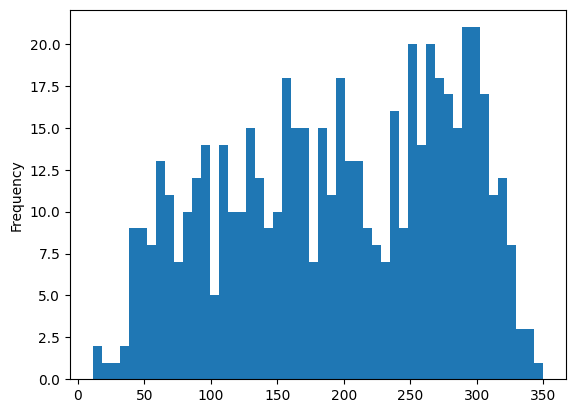

In [82]:
# Calculate review lengths and word count.
misclassified['review_length'] = misclassified['Review Text Preprocessed Lemma'].apply(len)
misclassified['word_count'] = misclassified['Review Text Preprocessed Lemma'].apply(lambda x: len(x.split()))

misclassified['review_length'].plot(kind='hist', bins=50)

## We can see that from here our model perform good with review text that has length more than 350, it always correctly predicted.
## But for less than 350 words our model doesn't perform very good.

### By WordCloud

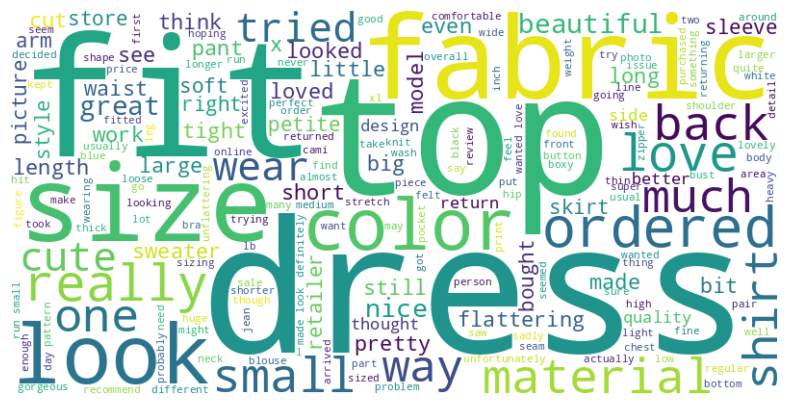

In [86]:
# Combine all review text into one large string
text = " ".join(misclassified['Review Text Preprocessed Lemma'])

# Create and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [93]:
misclassified.loc[misclassified['Review Text Preprocessed Lemma'].str.contains('fit'),:].sample(n=5, random_state=42)

,Recommended IND,predicted,correct,Review Text Preprocessed Lemma,Review Text
2744,1,0,False,like this top lot nice love design style fabric but run small curvy figure pull front see button pull bottom well usually wear l xl xl this one still bit fitted especially around bust still keeping hoping lose pound but nice top fabric design style stylish look casual model but dressy,"I like this top a lot, very nice. i love the design, style, and fabric. but it runs too small. i have a curvy figure, and it pulls in the front so you can see between the buttons, and pulls at the bottom as well. i usually wear l or xl, in xl this one was still a bit fitted especially around the bust. i am still keeping it - hoping to lose a few pounds. but it is a very nice top with the fabric, design, and style. very stylish! it looks casual on the model but can be dressy."
3036,1,0,False,tried this store today id say exactly pictured normal size fit loosely but unflattering way sizing might narrow shoulder embroidery seemed good quality but fabric thinner side lining would liked see liner this price but think wait promo sale,"Tried this in store today and id say it is exactly as pictured (length is similar on me at 5'7"", colors as shown, cut is loose but not overly sacklike). my normal size s fit loosely, but not in an unflattering way. sizing down might have been too narrow in the shoulders. the embroidery seemed to be good quality, but the fabric itself was on the thinner side with no lining. i would have liked to see a liner at this price (and probably would have bought), but i think i'll wait for a promo or sale"
1959,0,1,False,this dress cute but fit quite right bottom half fit well but top half little loose wearable but worried wearing hour would stretch even look frumpy like reviewer said this dress really need belt bring together ended returning love,"This dress was cute but the fit was not quite right. the bottom half fit well but the top half was a little loose. it was wearable but i was worried after wearing for a few hours it would stretch out even more and look frumpy. like other reviewers have said, this dress really needs a belt to bring it together. i ended up returning it because i didn't love it."
3741,0,1,False,start saying loved this dress tried dressing room knew color design beautiful fabric soft size but fit perfectly lb size fit great first time pulled home gently pulling zipper hit ribbon area side zipper seam split tried half hour get realign finally decided go exchange,"I'll start by saying that i loved this dress. i tried it on in the dressing room and knew i had to have it. the colors and design are beautiful and the fabric is soft. i did have to size up but it fit me perfectly once i did. i'm 5'1"" 130 lbs 34 d size 6 fit great. \r\nthe first time i pulled it out at home, i was gently pulling up the zipper and once it hits those ribbon areas on the side, the zipper seam split. i tried for a half hour to get it to realign. i finally decided to go exchange it for"
348,0,1,False,this dress fitted look model appear shift dress gorgeous print quality look great reference lb bought x whatever reason high neckline flattering personally think this dress perfect broad shoulder,"This dress isn't as fitted as it looks on the model. it appear to be more of a shift dress. as gorgeous as the print and quality are, it doesn't look great on me. for reference, i'm 5'5 105lbs and bought xs. for whatever reason, the high neckline isn't flattering on me. i do personally think this dress is perfect if you have broad shoulders."


In [95]:
misclassified.loc[misclassified['Review Text Preprocessed Lemma'].str.contains('top'),:].sample(n=5, random_state=42)

,Recommended IND,predicted,correct,Review Text Preprocessed Lemma,Review Text
3665,1,0,False,grabbed this sale state first think this top worth full price even wowed enough pay much color saturated person pretty however cut length width made overwhelming size frame ordered xl wayyyy big chest but sizing large meant flow hip well long think,"I grabbed this during a 20% off sale so i will state first that i don't think this top is worth full price, and even at 20% off i wasn't wowed enough to pay that much for it. the colors are more saturated in person and very pretty. however, the cut- both the length and the width- just made it too overwhelming on my size 14/16 frame. i ordered the xl and it was wayyyy too big through the chest but sizing down to a large meant that it didn't flow over my hips as well because it's so long. i think"
1354,0,1,False,short waisted still thought pleat started high also whole thing little bit big always wear medium but this top shoulder everything bit large since bought online size fabric nice quality,"I am short waisted and i still thought the pleats started too high on me. also, the whole thing was a little bit big. i always wear a medium, but in this top the shoulders and everything was just a bit large. since i bought it online, i couldn't size down. the fabric was a nice quality."
3868,0,1,False,this another one darned swing top even this trend this shirt nice print color palette going but ruined swing cut henley combo looked like little kid wearing oversized men night shirt smock know flattering ordered regular size large medium would worked probably still generously cut disagree reviewer said might work larger size this made,"This is another one of those darned swing tops. i can't even with this trend. this shirt has such a nice print/color palette going on but it's ruined by the swing cut/henley combo- it looked like i was a little kid wearing an oversized men's night shirt/smock? i don't know, it was just not at all flattering. i ordered my regular size large and a medium would have worked and probably still been generously cut. i disagree with a reviewer who said it might work for larger sizes.. this just made my"
3988,0,1,False,c bust bought this blouse even though wear sized based previous review this top super tight bust loose bottom flattering material gorgeous thick lined darted bust flare peplum fashion light fabric top meet dark band fabric middle problem busty lady find bust area wa,"I have a 36c bust. i bought this blouse in a 10, even though i wear an 8 or 10. i sized up based on previous reviews. this top was super tight in the bust (it literally flattened my breasts) and very loose on the bottom. it was not flattering at all. the material is gorgeous. it is thick. it is lined. it is darted at the bust and it flares out in a peplum fashion where the light fabric up top meets the dark band of fabric in the middle. the problem is that busty ladies will find the bust area wa"
3157,1,0,False,ordered this top white really excited come delivered tried took second decide liked think ordered size big somewhat boxy but think paired right pant shoe would wanted,"I ordered this top in white and i was really excited for it to come in! once it once delivered and i tried it on it took me a second to decide if i liked it or not. i think i ordered it a size too big (i ordered a large, i'm usually a medium). it was somewhat boxy, but i think paired with the right pants and shoes it would be just what i wanted!"


In [96]:
misclassified.loc[misclassified['Review Text Preprocessed Lemma'].str.contains('dress'),:].sample(n=5, random_state=42)

,Recommended IND,predicted,correct,Review Text Preprocessed Lemma,Review Text
3601,1,0,False,cute dress way big back dress much fabric hung form around waist appeared fitted model one received dress quite bit longer back felt like front riding minute trying sadly return come underneath slip necessary fabric thin recommend caution sizing,"Such a cute dress it was just way too big in the back of the dress, too much fabric, it just hung with\r\nno form around waist. it appeared more fitted on the model than the one i received. dress was quite\r\na bit longer in the back so i felt like the front was riding up just in the minutes of trying it on. \r\nsadly i have to return it. it did come with an underneath slip which was necessary as the fabric was very\r\nthin.\r\nrecommend with caution to sizing."
1222,0,1,False,purchased this dress yesterday cute fit great but embroidery across back ripped soon moved arm really delicate strain anytime lift arm overhead forward keeping anyway supersoft pretty slip come worth sale price,"I purchased this dress yesterday and it's cute and fits great, but the embroidery across the back ripped as soon as i moved my arms. it's really delicate and strains anytime you lift your arms overhead or forward. i'm keeping it anyway because the supersoft pretty slip that come with it is worth the sale price."
3790,1,0,False,saw this dress online thought looked ok happened see dress retailer store today thought would try glad this dress look much better usually dress retailer tried this large fit perfect cling but hang like sack either think made look taller thin woohoo would say little thinner side heavy knit two layer thinner knit yo,"I saw this dress online and thought it looked just ok. i happened to see the dress in my retailer store today, and thought i would try it. i'm so glad i did. this dress looks so much better on. i'm usually a 10-12 in dresses at retailer, i tried this in a large. it fit perfect. it's doesn't cling to you, but it doesn't hang like a sack either. i think it made me look taller and thin. woohoo. i would say it's a little on the thinner side, it's not a heavy knit. it's two layers of thinner knit , as yo"
4032,1,0,False,this maeve dress caught eye unique styling disappoint person v neckline deep but revealing nice hemstitch detail sleeve trim pattern good scale strong frame surprised dress actually black light brown flower screen looked brown bronze flower pocket this unlined dress placed seam but feel weirdly awkward access almost set back,"This maeve dress caught my eye for its unique styling, and did not disappoint in person. v-neckline is deep, but not revealing. there is a nice hemstitch detail on the sleeve trim. the pattern is a good scale for a strong frame.\r\nwhat surprised me: 1.) the dress is actually black with light brown flowers. on my screen, it looked brown with bronze flowers. 2.) there are pockets in this unlined dress! they are placed on-seam, but feel weirdly awkward to access, almost as if they are set back. they"
3099,1,0,False,this lovely piece great shape detail think would really stand event ended returning much occasion cocktail dress trouble sending back slip sheer overlay slip seemed bit tight bottom hem shape dress,"This is a lovely piece, with great shape and details. i think it would really stand out at events. i ended up returning it. i don't have much occasion for cocktail dresses. i had trouble sending it back. it has a slip with the sheer overlay. the slip seemed a bit tight at the bottom hem for the shape of the dress."


In [ ]:
# Based on those samples above, I see a pattern that the review text is quite complex, sometimes they say that it was lovely piece in the first place but in the end they returned it
# Which makes our models confuse. There are a lot of that type of review style like that, that are very complex.
# Sometimes the true label is 1 but the most of the text only say 1-3 positive words, and the remining are just experessing their not satisfication
# Action: we need to see if the label are correctly labeled or not.

## Transformer Model: BERT

### By Review Length

In [99]:
y_val['predicted_transformer'] = val_preds  # Add model predictions
y_val['correct_transformer'] = y_val['Recommended IND'] == y_val['predicted_transformer']  # Check correctness

# Get misclassified instances
misclassified_transformer = y_val[y_val['correct_transformer'] == False]

<Axes: ylabel='Frequency'>

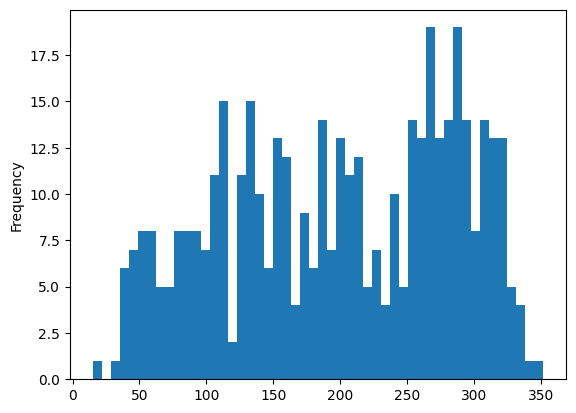

In [100]:
# Calculate review lengths and word count.
misclassified_transformer['review_length'] = misclassified_transformer['Review Text Preprocessed Lemma'].apply(len)
misclassified_transformer['word_count'] = misclassified_transformer['Review Text Preprocessed Lemma'].apply(lambda x: len(x.split()))

misclassified_transformer['review_length'].plot(kind='hist', bins=50)


## Quite the same with logistic regression model.
## We can see that from here our model perform good with review text that has length more than 350, it always correctly predicted.
## But for less than 350 words our model doesn't perform very good.

### By Word Cloud

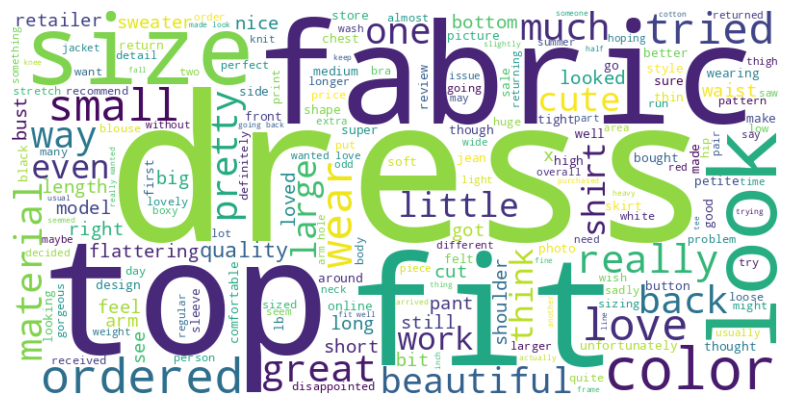

In [101]:
# Combine all review text into one large string
text = " ".join(misclassified_transformer['Review Text Preprocessed Lemma'])

# Create and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [103]:
misclassified_transformer.loc[misclassified_transformer['Review Text Preprocessed Lemma'].str.contains('fit'),:].sample(n=5, random_state=42)

,Recommended IND,predicted,correct,Review Text Preprocessed Lemma,Review Text,predicted_transformer,correct_transformer,review_length,word_count
2858,1,0,False,size xl review might apply people purchase retailer top size xl sometimes fit great sometimes put this top looked like wearing open cardigan nowhere near buttoning sewing experience removed box pleat gave additional inch fabric this able easily button blouse lay nicely but literally needed extra inch fabric mid,"I'm a size xl, so my review might not apply to all people. i purchase my retailer tops in size xl and sometimes they fit great and sometimes they don't. when i put this top on it looked like i was wearing an open cardigan; nowhere near buttoning. i have some sewing experience, so i removed all 4 box pleats which gave me an additional 8 inches of fabric. after doing this i was able to easily button up the blouse and have it lay nicely. but i literally needed that extra 8 inches of fabric in the mid",0,False,312,49
3837,1,0,False,bought this navy green but going back fit everywhere but upper arm even across chest usually encounter opposite think might way cut across shoulder allow much movement beautiful incredibly soft go back,"I bought this in both the navy (a more saturated blue in person - gorgeous!) and green, but both are going back. it fit everywhere but in the upper arms, even across my chest, and i usually encounter the opposite. i think it might just be the way it's cut across the shoulders that don't allow for much movement. so, while beautiful and so incredibly soft, it has to go back. (if you have slender arms, i think it would be a great fit.)",0,False,201,32
2244,0,0,True,this pretty shirt narrow across back need able move arm freely work this work may able size better fit moving arm important,"This is a very pretty shirt which is too narrow across the back. i need to be able to move my arms freely at work, so this did not work for me. you may be able to size up for a better fit if moving your arms is important to you.",1,False,123,22
1749,0,1,False,this top gorgeous fit perfectly right bag quick ironing unfortunately first time washed shrunk longer fit across bust without tape roomy much shorter feel rougher touch like another reviewer said wish label would said dry clean regret washing would done otherwise kno,"This top was gorgeous and fit perfectly right out of the bag, with only a quick ironing. unfortunately, the first time i washed it (cold water, hang dry), it shrunk so that it no longer fits across the bust without tape where it was once roomy, is much shorter, and feels rougher to the touch. like another reviewer said (unfortunately, after i had purchased and washed!), i wish the label would have just said to dry clean only, because i regret washing it and would have done otherwise if i had kno",1,False,267,42
2822,1,0,False,tried this store but almost thought would look like sack dress look good fit nicely shoulder give structure rest dress roomy but much look stupid im hit knee inch two,"I tried this on in the store, but almost didn't because i thought it would look like a sack. the dress looks so good. it fits nicely in the shoulders which gives structure and then the rest of the dress is roomy, but no so much it looks stupid. im 5'5"" and it hit above my knees by an inch or two.",0,False,166,30


In [104]:
misclassified_transformer.loc[misclassified_transformer['Review Text Preprocessed Lemma'].str.contains('dress'),:].sample(n=5, random_state=42)

,Recommended IND,predicted,correct,Review Text Preprocessed Lemma,Review Text,predicted_transformer,correct_transformer,review_length,word_count
2233,1,0,False,like another reviewer really wanted love this dress everything this screamed perfection length cut stripe but fit really usually size tried body fit well but chest strap entirely large tried size chest strap fit but body pulled button normally tailoring fit but chest would needed reconstructed,"Like another reviewer, i really wanted to love this dress. everything about this screamed perfection: the length, the cut, the stripes, but the fit was really off for me. i'm 5""10"" and am usually between a size 8 and 10. i tried the 8 and the body fit well but the chest and straps were entirely too large (i'm a 34d). so i tried the size 6 and chest and straps fit but the body pulled at the buttons. normally, i'm all for tailoring to fit, but chest would have needed to be reconstructed which isn'",0,False,294,46
3706,0,0,True,excited receiving this dress unfortunately little disappointed opened package color darker picture live florida sun always shining although this dress beautiful simple design color winter,"I was very excited about receiving this dress. unfortunately i was a little disappointed when i opened the package, as the color was darker than on the picture.\r\ni live in florida where the sun is always shining and although this dress has a beautiful simple design, it isn't for me as the color is too ""winter"".",1,False,187,25
1069,0,1,False,tried this usual x fit like dream instantly love looked side realized cut way short longer torso shorter leg this came past finger tip stood arm way could wear this dress tunic definitely though but really hoping find nice versatile fall dress let but still may consider purchasing material soft f,"I tried this on in my usual xs (5'5"", 128lbs) and it fit like a dream. i was instantly in love. until i looked from the side and realized it was cut up way too short. i have a longer torso and shorter legs and this came up past my finger tips if i stood with my arms down. no way could i wear this as a dress. as a tunic definitely though, but i was really hoping to find a nice, versatile fall dress. it was a let down but i still may consider purchasing it because the material was so soft and it f",1,False,297,51
1910,1,0,False,ordered this dress briefly sale extra percent excited receive usual size large wear jean jacket cowboy boot took package could tell looked really small even try daughter wear size small try even get hip tall thin like model work made cupro look exactly like photo color g,"I ordered this dress when it was briefly on sale with an extra percent off. i was very excited to receive it in my usual size large, and wear with a jean jacket and cowboy boots. when i took it out of the package, i could tell it looked really small. i didn't even try it on. i had my daughter who wears a size small try it on, and she couldn't even get it over her hips. if you are tall and thin like the model, it will work for you. it is made of cupro, looks exactly like the photo, the color is g",0,False,271,47
3130,1,1,True,this dress absolutely beautiful person but end working wear fit but g chest waistline sit low enough bust instead natural waist really wanted this work think would great right person seemed tt love detailing,"This dress was absolutely beautiful in person, but it didn't end up working out for me. i wear a 10, the 10 fit, but i have a 34g chest and because of that the waistline didn't sit low enough - it was just below my bust instead of at my natural waist. i really wanted this to work and think it would be great for the right person. seemed tts. love the detailing!",0,False,207,34


In [105]:
misclassified_transformer.loc[misclassified_transformer['Review Text Preprocessed Lemma'].str.contains('top'),:].sample(n=5, random_state=42)

,Recommended IND,predicted,correct,Review Text Preprocessed Lemma,Review Text,predicted_transformer,correct_transformer,review_length,word_count
1169,1,0,False,loved short however seemed doomed received july nd wore party july rd top shown fit true size style quality nice day first ripped low arbor gate latch later splashed red wine husband startled threw red wine air typically careful issue ruining clothes felt bad asked get new pair,"I loved these shorts; however, they seemed to be doomed! i received these on july 2nd & wore them at for a party we had on july 3rd, with the top shown. the fit was true to size, style & quality were nice. during the day i first ripped them on a low arbor gate latch, then later they were splashed with red wine when my husband startled me & i threw my red wine in the air. typically, i am very careful and do no have an issue with ruining my clothes. he felt so bad he asked me to get a new pair. i",0,False,278,48
2009,0,0,True,this dress seems quite high quality wonderfully designed except chest wrap style hug right place but chest slightly large chested but usually wear size small size dress top small this dress great everywhere else but breathe totally flattened chest also quite low cut another mark anyone semi large bust wear work reason,"This dress seems quite high quality and is wonderfully designed, except in the chest. the wrap style hugs in all the right places but the chest. i'm slightly large chested (34c/d) but can usually wear a size small or size 4 in dresses and tops (5'5"", 122 lbs). the small in this dress was great everywhere else, but i couldn't breathe and it totally flattened out my chest. also, it is quite low cut, so another mark against it for anyone with a semi-large bust. couldn't wear it to work that reason",1,False,319,52
2118,1,0,False,loved jumpsuit moment saw catalogue luckily one returned store near pound small fit perfectly but zipper top section difficult use would need help every morning get dressed zipper missing couple prong make return,"I loved the jumpsuit the moment i saw it in the catalogue and luckily there was one returned to the store near me! i am 5'10"" and 140 pounds. the small fit perfectly, but the zipper on the top section was so difficult to use that i would need help every morning to get dressed. the zipper was missing a couple prongs and i had to make the return.",0,False,212,33
3638,0,0,True,love this brand literally live top this one bit disappointment made fabric feel cheap reminding tissue tee instead normal thicker quality product thin see unless wearing camisole slip underneath perfect bra pant situation going underneath muffin top back fat got black keeping love design need black top desperat,"I love this brand, i literally live in their tops.. this one is a bit of a disappointment. it is made out of fabric that feels cheap, reminding me of a tissue tee instead of the normal thicker quality of all their other products. it's very thin, and see through. unless wearing a camisole/slip underneath, you have to have the perfect bra and pants situation going on underneath- no muffin tops or back fat!!i got the black, and am keeping it only because i love the design, need a black top desperat",1,False,312,48
134,1,1,True,craving this dress brown pattern jumped gun sale left size sp look like fool like trying wear top junior high pas dress shoulder,I've been craving this dress in the brown pattern for a while and should have jumped the gun before the sale. so now i was left with size sp and i look like a fool--like i'm trying to wear a top from junior high and pass it off as a dress. my shoulders,0,False,128,23


BERT is highly effective for review classification due to
- its bidirectional context understanding
- pre-training on massive data
- contextualized word embeddings
- ability to fine-tune for specific tasks
- and handling of complex language.

These features make BERT particularly suitable for tasks like sentiment analysis, which involves understanding nuances in the language, tone, and context of text—attributes that are critical when classifying product reviews in fashion.

Choosing the Right Model
- For short to medium-length reviews: BERT, RoBERTa, DistilBERT, and ALBERT are excellent choices, as they are powerful for classification tasks.
- For long reviews: Longformer or T5 could be better due to their ability to handle long documents efficiently.
- For a lightweight model: DistilBERT and ALBERT are ideal when computational efficiency is a priority.
- For external knowledge: ERNIE is a good choice if the reviews require knowledge of entities or relationships.

The choice of model largely depends on the size and length of your reviews, available computational resources, and the specific nature of the review classification task.

# Next Step
1. Check if there are a lot of slangs.
2. Use other columns like rating, title, age, positive feedback count, division name, department name and class name. Is there any correlation between these columns with the target variable?
3. There is always mention about height in feet, we can do more analyze in this.
4. Threshold Optimization.
5. Increase Code Quality and Organization

In [ ]:
df.columns

Index(['Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')